In [1]:
import ssms
import torch
import pickle
import numpy as np
import os
import lanfactory
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt

wandb not available
wandb not available


In [2]:
np.__version__

'1.26.3'

In [3]:
ssms.config.model_config['angle']

{'name': 'angle',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'hddm_include': ['z', 'theta'],
 'nchoices': 2}

In [4]:
from os import PathLike
from typing import Callable, Tuple

import pytensor 
pytensor.config.floatX = "float32"
import pytensor.tensor as pt
import jax.numpy as jnp
import numpy as np
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify
from jax import jit, vjp, vmap
from jax import grad, jit
from numpy.typing import ArrayLike

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

import pymc as pm
from pytensor.tensor.random.op import RandomVariable

import warnings 
warnings.filterwarnings('ignore')

class NetworkLike:
    @classmethod
    def make_logp_jax_funcs(
        cls,
        params_is_reg: list[bool],
        model = None,
        n_params: int | None = None,
        kind: str = 'lan',
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        """Makes a jax log likelihood function from flax network forward pass.
        Args:
            model: A path or url to the ONNX model, or an ONNX Model object
            already loaded.
            compile: Whether to use jit in jax to compile the model.
        Returns: A triple of jax or Python functions. The first calculates the
            forward pass, the second calculates the gradient, and the third is
            the forward-pass that's not jitted.
        """
        if kind == 'lan':
            def logp_lan(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial by trial likelihoods
                are derived from a LAN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                #params_matrix = jnp.repeat(
                #     jnp.stack(dist_params).reshape(1, -1), axis=0, repeats=data.shape[0]
                # )
                # params_matrix = jnp.transpose(jnp.stack(dist_params))
                # Set 'v' parameters depending on condition
                # params_matrix = params_matrix.at[:, 0].set(params_matrix[:, 0] * data[:, 2])

                # Stack parameters and data to have full input
                # input_matrix = jnp.hstack([params_matrix, data[:, :2]])

                input_matrix = jnp.concatenate((jnp.array(dist_params), data))

                ll = jnp.exp(model(input_matrix))

                # Network forward and sum
                return jnp.sum(
                    jnp.squeeze(jnp.log(ll))
                )
            # The vectorization of the logp function
            vmap_logp_lan = vmap(
                logp_lan,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            # logp_grad_lan = grad(logp_lan, argnums=range(1, 1 + n_params))
            # return jit(logp_lan), jit(logp_grad_lan), logp_lan
            
            def vjp_vmap_logp_lan(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_lan, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_lan), jit(vjp_vmap_logp_lan), vmap_logp_lan

        elif kind == 'cpn':
            def logp_cpn(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial-by-trial likelihood derive for a CPN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                # n_nogo_go_condition = jnp.sum(data > 0)
                # n_nogo_nogo_condition = jnp.sum(data < 0)
                # n_omission = jnp.sum(data>0)
                # n_total = jnp.sum(data>=0)

                params_matrix  = jnp.array(dist_params)

                # AF-TODO Bugfix here !
                # dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
                # dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])

                net_out = jnp.squeeze(model(params_matrix))

                # Include lapse distribution (uniform) into omission likelihood
                # dist_params[-1]: outlier
                # dist_params[-2]: deadline (in second)

                out = jnp.sum(jnp.multiply(jnp.log(1 - jnp.exp(net_out) + 1e-64),data))

                return out
            vmap_logp_cpn = vmap(
                logp_cpn,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            def vjp_vmap_logp_cpn(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_cpn, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_cpn), jit(vjp_vmap_logp_cpn), vmap_logp_cpn

    @staticmethod

    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_vjp: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> Op:
        """Wrap the JAX functions and its gradient in pytensor Ops.

        Parameters
        ----------
        logp
            A JAX function that represents the feed-forward operation of the LAN
            network.
        logp_vjp
            The Jax function that calculates the VJP of the logp function.
        logp_nojit
            The non-jit version of logp.

        Returns
        -------
        Op
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class LANLogpOp(Op):  # pylint: disable=W0223
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation. The parameters
                    can be both scalars and arrays.
                """
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.vector()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    output_storage are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_gradients):
                """Perform the pytensor.grad() operation.

                Parameters
                ----------
                inputs
                    The same as the inputs produced in `make_node`.
                output_gradients
                    Holds the results of the perform `perform` method.

                Notes
                -----
                    It should output the VJP of the Op. In other words, if this `Op`
                    outputs `y`, and the gradient at `y` is grad(x), the required output
                    is y*grad(x).
                """
                results = lan_logp_vjp_op(inputs[0], *inputs[1:], gz=output_gradients[0])
                output = [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + results

                return output

        class LANLogpVJPOp(Op):  # pylint: disable=W0223
            """Wraps the VJP operation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params, gz):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data:
                    A two-column numpy array with response time and response.
                dist_params:
                    A list of parameters used in the likelihood computation.
                """
                inputs = (
                    [
                        pt.as_tensor_variable(data),
                    ]
                    + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                    + [pt.as_tensor_variable(gz)]
                )
                outputs = [inp.type() for inp in inputs[1:-1]]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    `output_storage` are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                results = logp_vjp(inputs[0], *inputs[1:-1], gz=inputs[-1])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        lan_logp_op = LANLogpOp()
        lan_logp_vjp_op = LANLogpVJPOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(LANLogpOp)
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return lan_logp_op


In [5]:
# Loaded Net
model_config = ssms.config.model_config['angle']

jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
    network_config="../network/angle/lan/96f2b24a933211ee99b9a0423f3e9a40_lan_angle__network_config.pickle",
    train=False,
)

forward_pass_lan, forward_pass_jitted_lan = jax_infer_lan.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="../network/angle/lan/96f2b24a933211ee99b9a0423f3e9a40_lan_angle__train_state.jax",
    add_jitted=True,
)

passing through identity


In [6]:
# Loaded Net
jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
    network_config="../network/angle/cpn/338ff01ca91911ee91a3a0423f3e9b42_cpn_angle__network_config.pickle",
    train=False,
)

forward_pass_cpn, forward_pass_jitted_cpn = jax_infer_cpn.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 1,
    state="../network/angle/cpn/338ff01ca91911ee91a3a0423f3e9b42_cpn_angle__train_state.jax",
    add_jitted=True,
)

passing through transform


In [7]:
import logging
from os import PathLike
from typing import Any, Callable, Type
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
from numpy.typing import ArrayLike
from pytensor.graph.op import Apply, Op
from pytensor.tensor.random.op import RandomVariable
from ssms.basic_simulators.simulator import simulator
from ssms.config import model_config as ssms_model_config

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]


LOGP_LB = pm.floatX(-66.1)


def apply_param_bounds_to_loglik(
    logp: Any,
    list_params: list[str],
    *dist_params: Any,
    bounds: dict[str, tuple[float, float]],
):
    """Adjust the log probability of a model based on parameter boundaries.

    Parameters
    ----------
    logp
        The log probability of the model.
    list_params
        A list of strings representing the names of the distribution parameters.
    dist_params
        The distribution parameters.
    bounds
        Boundaries for parameters in the likelihood.

    Returns
    -------
        The adjusted log likelihoods.
    """
    dist_params_dict = dict(zip(list_params, dist_params))

    bounds = {k: (pm.floatX(v[0]), pm.floatX(v[1])) for k, v in bounds.items()}
    out_of_bounds_mask = pt.zeros_like(logp, dtype=bool)

    for param_name, param in dist_params_dict.items():
        # It cannot be assumed that each parameter will have bounds.
        # Skip the paramters that do not have bounds.
        if param_name not in bounds:
            continue

        lower_bound, upper_bound = bounds[param_name]

        param_mask = pt.bitwise_or(pt.lt(param, lower_bound), pt.gt(param, upper_bound))
        out_of_bounds_mask = pt.bitwise_or(out_of_bounds_mask, param_mask)

    logp = pt.where(out_of_bounds_mask, LOGP_LB, logp)

    return logp


def ensure_positive_ndt(data, logp, list_params, dist_params):
    """Ensure that the non-decision time is always positive.

    Replaces the log probability of the model with a lower bound if the non-decision
    time is not positive.

    Parameters
    ----------
    data
        A two-column numpy array with response time and response.
    logp
        The log-likelihoods.
    list_params
        A list of parameters that the log-likelihood accepts. The order of the
        parameters in the list will determine the order in which the parameters
        are passed to the log-likelihood function.
    dist_params
        A list of parameters used in the likelihood computation. The parameters
        can be both scalars and arrays.

    Returns
    -------
    float
        The log-likelihood of the model.
    """
    rt = data[:, 0]

    if "t" not in list_params:
        return logp

    t = dist_params[list_params.index("t")]

    return pt.where(
        # consistent with the epsilon in the analytical likelihood
        rt - t <= 1e-15,
        LOGP_LB,
        logp,
    )


def make_ssm_rv(
    model_name: str, list_params: list[str], lapse: Any
) -> Type[RandomVariable]:
    """Build a RandomVariable Op according to the list of parameters.

    Parameters
    ----------
    model_name
        The name of the model. If the `model_name` is not one of the supported
        models in the `ssm_simulators` package, a warning will be raised, and any
        attempt to sample from the RandomVariable will result in an error.
    list_params
        A list of str of all parameters for this `RandomVariable`.
    lapse : optional
        A bmb.Prior object representing the lapse distribution.

    Returns
    -------
    Type[RandomVariable]
        A class of RandomVariable that are to be used in a `pm.Distribution`.
    """

    # pylint: disable=W0511, R0903
    class SSMRandomVariable(RandomVariable):
        """SSM random variable."""

        name: str = "SSM_RV"
        # to get around the support checking in PyMC that would result in error
        ndim_supp: int = 1

        ndims_params: list[int] = [0 for _ in list_params]
        dtype: str = "floatX"
        _print_name: tuple[str, str] = ("SSM", "\\operatorname{SSM}")
        _list_params = list_params

        # PyTensor, as of version 2.12, enforces a check to ensure that
        # at least one parameter has the same ndims as the support.
        # This overrides that check and ensures that the dimension checks are correct.
        # For more information, see this issue
        # https://github.com/lnccbrown/HSSM/issues/36
        def _supp_shape_from_params(*args, **kwargs):
            return (2,)

        # pylint: disable=arguments-renamed,bad-option-value,W0221
        # NOTE: `rng` now is a np.random.Generator instead of RandomState
        # since the latter is now deprecated from numpy
        @classmethod
        def rng_fn(
            cls,
            rng: np.random.Generator,
            *args,
            **kwargs,
        ) -> np.ndarray:
            """Generate random variables from this distribution.

            Parameters
            ----------
            rng
                A `np.random.Generator` object for random state.
            args
                Unnamed arguments of parameters, in the order of `_list_params`, plus
                the last one as size.
            kwargs
                Other keyword arguments passed to the ssms simulator.

            Returns
            -------
            np.ndarray
                An array of `(rt, response)` generated from the distribution.

            Note
            ----
            How size is handled in this method:

            We apply multiple tricks to get this method to work with ssm_simulators.

            First, size could be an array with one element. We squeeze the array and
            use that element as size.

            Then, size could depend on whether the parameters passed to this method.
            If all parameters passed are scalar, that is the easy case. We just
            assemble all parameters into a 1D array and pass it to the `theta`
            argument. In this case, size is number of observations.

            If one of the parameters is a vector, which happens one or more parameters
            is the target of a regression. In this case, we take the size of the
            parameter with the largest size. If size is None, we will set size to be
            this largest size. If size is not None, we check if size is a multiple of
            the largest size. If not, an error is thrown. Otherwise, we assemble the
            parameter as a matrix and pass it as the `theta` argument. The multiple then
            becomes how many samples we draw from each trial.
            """
            # First figure out what the size specified here is
            # Since the number of unnamed arguments is undetermined,
            # we are going to use this hack.
            if "size" in kwargs:
                size = kwargs.pop("size")
            else:
                size = args[-1]
                args = args[:-1]

            if size is None:
                size = 1

            # Although we got around the ndims_supp issue, the size parameter passed
            # here is still an array with one element. We need to take it out.
            if not np.isscalar(size):
                size = np.squeeze(size)

            num_params = len(cls._list_params)

            # TODO: We need to figure out what to do with extra_fields when
            # doing posterior predictive sampling. Right now nothing is done.
            if num_params < len(args):
                arg_arrays = [np.asarray(arg) for arg in args[:num_params]]
            else:
                arg_arrays = [np.asarray(arg) for arg in args]

            p_outlier = None

            if cls._list_params[-1] == "p_outlier":
                p_outlier = np.squeeze(arg_arrays.pop(-1))

            iinfo32 = np.iinfo(np.uint32)
            seed = rng.integers(0, iinfo32.max, dtype=np.uint32)

            params = (
                cls._list_params[:-1]
                if cls._list_params[-1] == "p_outlier"
                else cls._list_params
            )

            if params != ssms_model_config[model_name]["params"]:
                raise ValueError(
                    f"The list of parameters in `list_params` {params} "
                    + "is different from the model config in SSM Simulators "
                    + f"({ssms_model_config[model_name]['params']})."
                )

            is_all_scalar = all(arg.size == 1 for arg in arg_arrays)

            if is_all_scalar:
                # All parameters are scalars

                theta = np.stack(arg_arrays)
                n_samples = size
            else:
                # Preprocess all parameters, reshape them into a matrix of dimension
                # (size, n_params) where size is the number of elements in the largest
                # of all parameters passed to *arg

                elem_max_size = np.argmax([arg.size for arg in arg_arrays])
                max_shape = arg_arrays[elem_max_size].shape

                new_data_size = max_shape[-1]

                theta = np.column_stack(
                    [np.broadcast_to(arg, max_shape).reshape(-1) for arg in arg_arrays]
                )

                if size is None or size == 1:
                    n_samples = 1
                elif size % new_data_size != 0:
                    raise ValueError(
                        "`size` needs to be a multiple of the size of data"
                    )
                else:
                    n_samples = size // new_data_size

            sim_out = simulator(
                theta=theta,
                model=model_name,
                n_samples=n_samples,
                random_state=seed,
                **kwargs,
            )

            sims_out = np.column_stack([sim_out["rts"], sim_out["choices"]])

            if not is_all_scalar:
                sims_out = sims_out.reshape(
                    (*max_shape[:-1], max_shape[-1] * n_samples, 2)
                )


            return sims_out

    return SSMRandomVariable


def make_distribution(
    rv: str | Type[RandomVariable],
    loglik: LogLikeFunc | pytensor.graph.Op,
    list_params: list[str],
    bounds: dict | None = None,
    lapse: pm.Distribution | None = None,
    lapse_arg: dict | None = None,
    extra_fields: list[np.ndarray] | None = None,
) -> Type[pm.Distribution]:
    """Make a `pymc.Distribution`.

    Constructs a `pymc.Distribution` from a log-likelihood function and a
    RandomVariable op.

    Parameters
    ----------
    rv
        A RandomVariable Op (a class, not an instance) or a string indicating the model.
        If a string, a RandomVariable class will be created automatically with its
        `rng_fn` class method generated using the simulator identified with this string
        from the `ssm_simulators` package. If the string is not one of the supported
        models in the `ssm_simulators` package, a warning will be raised, and any
        attempt to sample from the RandomVariable will result in an error.
    loglik
        A loglikelihood function. It can be any Callable in Python.
    list_params
        A list of parameters that the log-likelihood accepts. The order of the
        parameters in the list will determine the order in which the parameters
        are passed to the log-likelihood function.
    bounds : optional
        A dictionary with parameters as keys (a string) and its boundaries as values.
        Example: {"parameter": (lower_boundary, upper_boundary)}.
    lapse : optional
        A bmb.Prior object representing the lapse distribution.
    extra_fields : optional
        An optional list of arrays that are stored in the class created and will be
        used in likelihood calculation. Defaults to None.

    Returns
    -------
    Type[pm.Distribution]
        A pymc.Distribution that uses the log-likelihood function.
    """
    random_variable = make_ssm_rv(rv, list_params, lapse) if isinstance(rv, str) else rv
    if lapse is not None:
        if list_params[-1] != "p_outlier":
            list_params.append("p_outlier")

        data_vector = pt.dvector()
        lapse_logp = pm.logp(
            lapse.dist(**lapse_arg),
            data_vector,
        )
        lapse_func = pytensor.function(
            [data_vector],
            lapse_logp,
        )

    class SSMDistribution(pm.Distribution):
        """Wiener first-passage time (WFPT) log-likelihood for LANs."""

        # This is just a placeholder because pm.Distribution requires an rv_op
        # Might be updated in the future once

        # NOTE: rv_op is an INSTANCE of RandomVariable
        rv_op = random_variable()
        params = list_params
        _extra_fields = extra_fields

        @classmethod
        def dist(cls, **kwargs):  # pylint: disable=arguments-renamed
            dist_params = [
                pt.as_tensor_variable(pm.floatX(kwargs[param])) for param in cls.params
            ]
            if cls._extra_fields:
                dist_params += [pm.floatX(field) for field in cls._extra_fields]
            other_kwargs = {k: v for k, v in kwargs.items() if k not in cls.params}
            return super().dist(dist_params, **other_kwargs)

        def logp(data, *dist_params):  # pylint: disable=E0213
            num_params = len(list_params)
            extra_fields = []

            if num_params < len(dist_params):
                extra_fields = dist_params[num_params:]
                dist_params = dist_params[:num_params]

            if list_params[-1] == "p_outlier":
                p_outlier = dist_params[-1]
                dist_params = dist_params[:-1]
                lapse_logp = lapse_func(data[:, 0].eval())

                logp = loglik(data, *dist_params, *extra_fields)
                logp = pt.log(
                    (1.0 - p_outlier) * pt.exp(logp)
                    + p_outlier * pt.exp(lapse_logp)
                    + 1e-29
                )
            else:
                logp = loglik(data, *dist_params, *extra_fields)

            if bounds is not None:
                logp = apply_param_bounds_to_loglik(
                    logp, list_params, *dist_params, bounds=bounds
                )
                
            

            # Ensure that non-decision time is always smaller than rt.
            # Assuming that the non-decision time parameter is always named "t".
            if list_params[-1] == "p_outlier":
                return ensure_positive_ndt(data, logp, list_params, dist_params)
            else:
                return logp

    return SSMDistribution

In [8]:
# Make some hierarchical data

n_subjects = 30  # number of subjects
n_trials = 1000  # number of trials per subject

sd_v = 0.1  # sd for v-intercept
mean_v = 1  # mean for v-intercept

sd_a = 0.1  # sd for v-intercept
mean_a = 1  # mean for v-intercept

sd_theta = 0.1  # sd for v-intercept
mean_theta = 0.6  # mean for v-intercept

data_list = []
for i in range(n_subjects):
    # Make parameters for subject i
    v = np.random.normal(mean_v, sd_v, size=1)
    a = np.random.normal(mean_a, sd_a, size=1)
    theta = np.random.normal(mean_theta, sd_theta, size=1)

    true_values = np.repeat([[v[0], a[0], 0.5, 0.3, theta[0]]], axis=0, repeats=n_trials)

    # Simulate data
    obs_ddm_reg_v = ssms.basic_simulators.simulator.simulator(
            model='angle', theta=true_values, n_samples=1
        )
    # Append simulated data to list
    data_list.append(
        pd.DataFrame(
            {
                "rt": obs_ddm_reg_v["rts"].flatten(),
                "response": obs_ddm_reg_v["choices"].flatten(),
                "subject": i,
            }
        )
    )

# Make single dataframe out of subject-wise datasets
dataset = pd.concat(data_list)
dataset

,rt,response,subject
0,0.916593,1,0
1,0.949692,1,0
2,0.534753,-1,0
3,0.913068,1,0
4,0.862053,1,0
...,...,...,...
995,0.731521,1,29
996,1.090807,1,29
997,0.442849,-1,29
998,0.707993,1,29


In [10]:
dataset_commission = dataset.loc[dataset.rt<=1.25]

(array([1094., 4189., 5115., 4603., 4093., 3345., 2510., 1777., 1291.,
         850.]),
 array([0.34255517, 0.43329811, 0.52404106, 0.61478406, 0.70552701,
        0.79626995, 0.8870129 , 0.97775584, 1.06849885, 1.1592418 ,
        1.24998474]),
 <BarContainer object of 10 artists>)

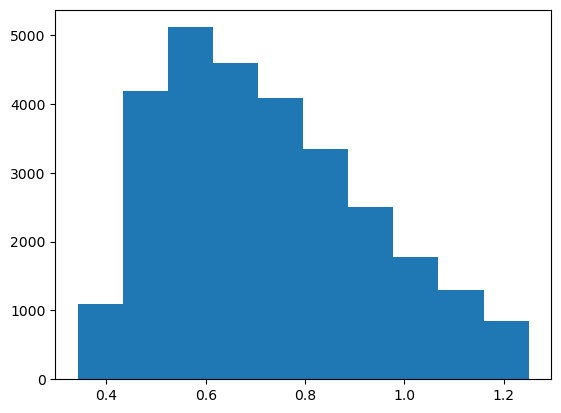

In [11]:
plt.hist(dataset_commission['rt'])

## Point inference

In [13]:
# Instantiate LAN logp functions
lan_logp_jitted, lan_logp_vjp_jitted, lan_logp = NetworkLike.make_logp_jax_funcs(model = forward_pass_lan,
                                                                                  n_params = 5,
                                                                                  kind = "lan",
                                                                                  params_is_reg=[False] * 5)

# Turn into logp op
lan_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = lan_logp_jitted,
                                logp_vjp = lan_logp_vjp_jitted,
                                logp_nojit = lan_logp)

# Instantiate CPN logp functions
cpn_logp_jitted, cpn_logp_vjp_jitted, cpn_logp = NetworkLike.make_logp_jax_funcs(
                                                                                                    model = forward_pass_cpn,
                                                                                                    n_params = 6,
                                                                                                    kind = "cpn",
params_is_reg=[False]*6)

# Turn into logp op
cpn_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = cpn_logp_jitted,
                                logp_vjp = cpn_logp_vjp_jitted,
                                logp_nojit = cpn_logp)

testDistLAN = make_distribution(
    'fake',
    lan_logp_op,
    ['v','a','z','t','theta'],
    {'v':(-3,3),'a':(0.3,2.5),'z':(0.1,0.9),'t':(0.1,1),'theta':(0,1.2)},
    pm.Uniform,
    {'name':'lapse','lower':0.001,'upper':1.25}
)

testDistCPN = make_distribution(
    'fake',
    cpn_logp_op,
    ['v','a','z','t','theta','deadline'],
    {'v':(-3,3),'a':(0.3,2.5),'z':(0.1,0.9),'t':(0.1,1),'theta':(0,1.2)},
    None,
    None
)

from pymc.sampling import jax as pmj

with pm.Model() as ddm:
    # Define simple Uniform priors
    v1 = pm.Uniform("v", -3.0, 3.0)
    a1 = pm.Uniform("a", 0.3, 2.5)
    z = pt.constant(0.5)
    t = pm.Uniform("t", 0.0, 1.0)
    theta =pm.Uniform("theta", 0.0, 1.2)
    p_outlier = pm.ConstantData("p_outlier",0.001)
    # t = pm.Uniform("t", 0.0, 2.0)
    # theta = pm.Uniform("theta",0,1.3)
    ddl = pm.ConstantData("ddl",1.25)


    testDistLAN("choice_rt", v=v1, a=a1, z=z, t=t, theta=theta, p_outlier=p_outlier,observed=dataset_commission[['rt','response']])
    testDistCPN("omission", v=v1, a=a1, z=z, t=t, theta=theta, deadline=ddl,observed=dataset['rt']>1.25)
    
    ddm_blog_traces_numpyro_d = pmj.sample_numpyro_nuts(
            chains=2, draws=1000, tune=1000,target_accept=0.9,chain_method='vectorized'
            )
    # ddm_blog_traces_numpyro_d = pm.sample(nuts_sampler='numpyro')
    post_summary = pm.summary(ddm_blog_traces_numpyro_d)

Compiling...


passing through identity
passing through transform


Compilation time = 0:00:02.052425
Sampling...


passing through transform
passing through identity


  0%|          | 0/2000 [00:00<?, ?it/s]

passing through transform
passing through identity


sample: 100%|██████████| 2000/2000 [26:55<00:00,  1.24it/s] 
Sampling time = 0:26:58.449381
Transforming variables...
Transformation time = 0:00:00.177611


In [14]:
pm.summary(ddm_blog_traces_numpyro_d)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.962,0.008,0.945,0.976,0.0,0.0,999.0,990.0,1.0
a,0.904,0.006,0.894,0.914,0.0,0.0,603.0,768.0,1.0
t,0.315,0.001,0.312,0.318,0.0,0.0,754.0,1085.0,1.0
theta,0.472,0.007,0.460,0.484,0.0,0.0,642.0,651.0,1.0


In [15]:
# Instantiate LAN logp functions
lan_logp_jitted, lan_logp_vjp_jitted, lan_logp = NetworkLike.make_logp_jax_funcs(model = forward_pass_lan,
                                                                                  n_params = 5,
                                                                                  kind = "lan",
                                                                                  params_is_reg=[True,True,False,False,True])

# Turn into logp op
lan_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = lan_logp_jitted,
                                logp_vjp = lan_logp_vjp_jitted,
                                logp_nojit = lan_logp)

# Instantiate CPN logp functions
cpn_logp_jitted, cpn_logp_vjp_jitted, cpn_logp = NetworkLike.make_logp_jax_funcs(
                                                                                                    model = forward_pass_cpn,
                                                                                                    n_params = 6,
                                                                                                    kind = "cpn",
params_is_reg=[True,True,False,False,True] + [False])

# Turn into logp op
cpn_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = cpn_logp_jitted,
                                logp_vjp = cpn_logp_vjp_jitted,
                                logp_nojit = cpn_logp)

testDistLAN = make_distribution(
    'fake',
    lan_logp_op,
    ['v','a','z','t','theta'],
    {'v':(-3,3),'a':(0.3,2.5),'z':(0.1,0.9),'t':(0.1,1),'theta':(0,1.2)},
    pm.Uniform,
    {'name':'lapse','lower':0.001,'upper':1.25}
)

testDistCPN = make_distribution(
    'fake',
    cpn_logp_op,
    ['v','a','z','t','theta','deadline'],
    {'v':(-3,3),'a':(0.3,2.5),'z':(0.1,0.9),'t':(0.1,1),'theta':(0,1.2)},
    None,
    None
)



coords = {
    "id": dataset.subject.unique(),  # actual group names
    "observation1": np.arange(dataset_commission.shape[0]),  # or use this, `data.index.values
    "observation2": np.arange(dataset.shape[0])
}

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    mu_v = pm.Uniform('mu_v',lower=-3,upper=3,initval=0)
    sigma_v = pm.HalfCauchy('sigma_v',beta=0.1)
    v_subj = pm.Normal('v_subj',mu=mu_v,sigma=sigma_v,dims='id')
    
    # a = pm.Uniform('a',lower=0.3,upper=2.5)
    # theta = pm.Uniform('theta',lower=0.1,upper=1.2)
    # a = pm.ConstantData('a',1)
    mu_theta = pm.Uniform('mu_theta',lower=0.1,upper=1.3,initval=0.5)
    sigma_theta = pm.HalfCauchy('sigma_theta',beta=0.1)
    theta_subj = pm.Normal('theta_subj',mu=mu_theta,sigma=sigma_theta,dims='id')
    
    mu_a = pm.Uniform('mu_a',lower=0.3,upper=2.5,initval=1)
    sigma_a = pm.HalfCauchy('sigma_a',beta=0.1)
    a_subj = pm.Normal('a_subj',mu=mu_a,sigma=sigma_a,dims='id')
        
#     mu_theta = pm.Uniform('mu_theta',lower=0,upper=1.2,initval=0.5)
#     sigma_theta = pm.HalfCauchy('sigma_theta',beta=0.1)
#     theta_subj = pm.TruncatedNormal('theta_subj',mu=mu_theta,sigma=sigma_theta,dims='id',lower=0,upper=1.2)
    
    idx1 = pm.ConstantData('idx1',dataset_commission.subject,dims='observation1')
    idx2 = pm.ConstantData('idx2',dataset.subject,dims='observation2')
    z = pm.ConstantData('z',0.5)
    t = pm.Uniform('t',lower=0.001,upper=1)
    deadline = pm.ConstantData('deadline',1.25)


    testDistLAN("choice_rt", v=v_subj[idx1], a=a_subj[idx1], z=z, t=t, theta=theta_subj[idx1], p_outlier=0,observed=dataset_commission[['rt','response']])
    testDistCPN("omission", v=v_subj[idx2], a=a_subj[idx2], z=z, t=t, theta=theta_subj[idx2],deadline=deadline,observed=dataset[['rt']]>1.25)

    ddm_blog_traces_numpyro_d = pmj.sample_numpyro_nuts(
            chains=2, draws=1000, tune=1000,target_accept=0.9,chain_method='vectorized'
            )
# trace.to_netcdf("model_" + starttime + ".nc")

Compiling...


passing through identity
passing through transform


Compilation time = 0:00:02.976510
Sampling...


passing through transform
passing through identity


  0%|          | 0/2000 [00:00<?, ?it/s]

passing through transform
passing through identity


warmup:   4%|▍         | 85/2000 [14:22<5:23:41, 10.14s/it] 


KeyboardInterrupt: 

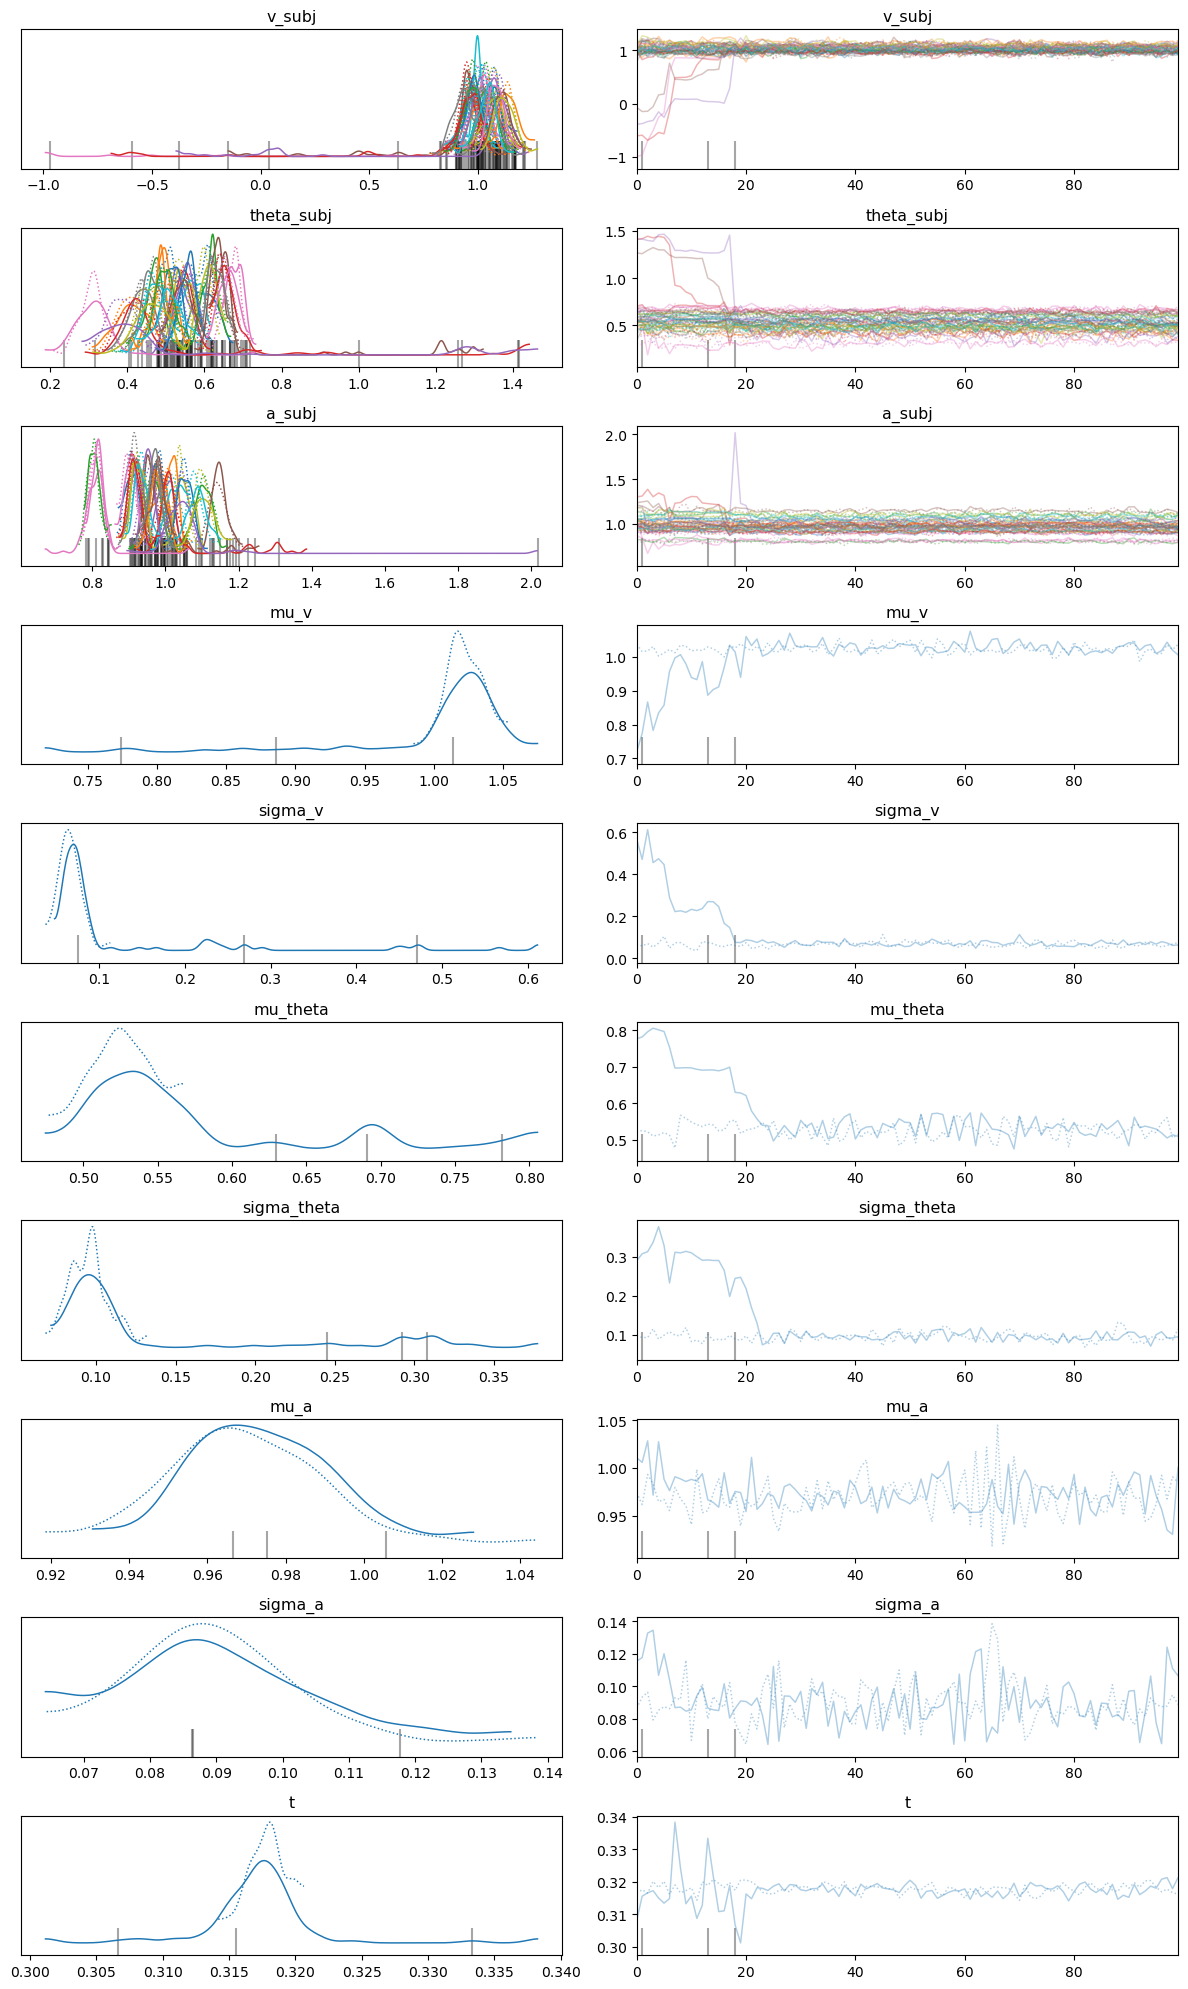

In [15]:
pm.plot_trace(ddm_blog_traces_numpyro_d)
plt.tight_layout()